In [1]:
# For time-series data, you would want to use something like a prophet model however, boosted models do the best in
# Kaggle time competition. It's obvious from the data (see EDA), the relationship between the dependent var: 
# num_sold and the rest of the independent variables is non-linear. This data is highly stationary and has
# high seasonality. 

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import holidays
import seaborn as sns

In [2]:
#Data without holiday
df = pd.read_csv('train.csv')
df.head()

,id,date,country,store,product,num_sold
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49


In [3]:
# Filter out data during the COVID-19 pandemic sales boom

covid_start_date = pd.to_datetime('2020-03-01')
covid_end_date = pd.to_datetime('2021-02-28')

# Convert date col to datetime
df['date'] = pd.to_datetime(df['date'])


df = df[~((df['date'] >= covid_start_date) & (df['date'] <= covid_end_date))]

# rename columns (This is for Prophet)
df = df.rename(columns={'date': 'ds', 'num_sold': 'y'})

df['ds'] = pd.to_datetime(df['ds'])



# create day, month, year column
df["day"] = df["ds"].dt.day
df["month"] = df["ds"].dt.month
df["year"] = df["ds"].dt.year

# check if date is a weekday or weekend
df["day_of_week"] = df["ds"].dt.dayofweek
df['weekend'] = df['day_of_week'].apply(lambda x: True if x > 4 else False)

# Define the holiday country sets you are interested in
country_holidays = {
    "Argentina": holidays.Argentina(),
    "Japan": holidays.Japan(),
    "Estonia": holidays.Estonia(),
    "Spain": holidays.Spain(),
    "Canada": holidays.Canada()
}

# check if date is a holiday for each country
df['is_holiday'] = False
for index, row in df.iterrows():
    if row['ds'] in country_holidays[row['country']]:
        df.loc[index, 'is_holiday'] = True

# create cyclic date features (Fourier Features for highly seasonal data)
df['month_sin'] = np.sin(2*np.pi*df.month/12)
df['month_cos'] = np.cos(2*np.pi*df.month/12)
df['day_sin'] = np.sin(2*np.pi*df.day/31)
df['day_cos'] = np.cos(2*np.pi*df.day/31)

# One-hot encoding
df_encoded = pd.get_dummies(df, columns=['country'])
df_encoded

,id,ds,store,product,y,day,month,year,day_of_week,weekend,is_holiday,month_sin,month_cos,day_sin,day_cos,country_Argentina,country_Canada,country_Estonia,country_Japan,country_Spain
0,0,2017-01-01,Kaggle Learn,Using LLMs to Improve Your Coding,63,1,1,2017,6,True,True,5.000000e-01,0.866025,2.012985e-01,0.97953,1,0,0,0,0
1,1,2017-01-01,Kaggle Learn,Using LLMs to Train More LLMs,66,1,1,2017,6,True,True,5.000000e-01,0.866025,2.012985e-01,0.97953,1,0,0,0,0
2,2,2017-01-01,Kaggle Learn,Using LLMs to Win Friends and Influence People,9,1,1,2017,6,True,True,5.000000e-01,0.866025,2.012985e-01,0.97953,1,0,0,0,0
3,3,2017-01-01,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59,1,1,2017,6,True,True,5.000000e-01,0.866025,2.012985e-01,0.97953,1,0,0,0,0
4,4,2017-01-01,Kaggle Learn,Using LLMs to Write Better,49,1,1,2017,6,True,True,5.000000e-01,0.866025,2.012985e-01,0.97953,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136945,136945,2021-12-31,Kagglazon,Using LLMs to Improve Your Coding,700,31,12,2021,4,False,False,-2.449294e-16,1.000000,-2.449294e-16,1.00000,0,0,0,0,1
136946,136946,2021-12-31,Kagglazon,Using LLMs to Train More LLMs,752,31,12,2021,4,False,False,-2.449294e-16,1.000000,-2.449294e-16,1.00000,0,0,0,0,1
136947,136947,2021-12-31,Kagglazon,Using LLMs to Win Friends and Influence People,111,31,12,2021,4,False,False,-2.449294e-16,1.000000,-2.449294e-16,1.00000,0,0,0,0,1
136948,136948,2021-12-31,Kagglazon,Using LLMs to Win More Kaggle Competitions,641,31,12,2021,4,False,False,-2.449294e-16,1.000000,-2.449294e-16,1.00000,0,0,0,0,1


In [4]:
#Product mapping/one-hot encoding

one_hot_encoded = pd.get_dummies(df['product'], prefix='Category')

# Concatenate the one-hot encoded DataFrame with the original DataFrame
df_encoded = pd.concat([df, one_hot_encoded], axis=1)

# Drop the original 'product' column
df_encoded.drop('product', axis=1, inplace=True)

df_encoded


,id,ds,country,store,y,day,month,year,day_of_week,weekend,is_holiday,month_sin,month_cos,day_sin,day_cos,Category_Using LLMs to Improve Your Coding,Category_Using LLMs to Train More LLMs,Category_Using LLMs to Win Friends and Influence People,Category_Using LLMs to Win More Kaggle Competitions,Category_Using LLMs to Write Better
0,0,2017-01-01,Argentina,Kaggle Learn,63,1,1,2017,6,True,True,5.000000e-01,0.866025,2.012985e-01,0.97953,1,0,0,0,0
1,1,2017-01-01,Argentina,Kaggle Learn,66,1,1,2017,6,True,True,5.000000e-01,0.866025,2.012985e-01,0.97953,0,1,0,0,0
2,2,2017-01-01,Argentina,Kaggle Learn,9,1,1,2017,6,True,True,5.000000e-01,0.866025,2.012985e-01,0.97953,0,0,1,0,0
3,3,2017-01-01,Argentina,Kaggle Learn,59,1,1,2017,6,True,True,5.000000e-01,0.866025,2.012985e-01,0.97953,0,0,0,1,0
4,4,2017-01-01,Argentina,Kaggle Learn,49,1,1,2017,6,True,True,5.000000e-01,0.866025,2.012985e-01,0.97953,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136945,136945,2021-12-31,Spain,Kagglazon,700,31,12,2021,4,False,False,-2.449294e-16,1.000000,-2.449294e-16,1.00000,1,0,0,0,0
136946,136946,2021-12-31,Spain,Kagglazon,752,31,12,2021,4,False,False,-2.449294e-16,1.000000,-2.449294e-16,1.00000,0,1,0,0,0
136947,136947,2021-12-31,Spain,Kagglazon,111,31,12,2021,4,False,False,-2.449294e-16,1.000000,-2.449294e-16,1.00000,0,0,1,0,0
136948,136948,2021-12-31,Spain,Kagglazon,641,31,12,2021,4,False,False,-2.449294e-16,1.000000,-2.449294e-16,1.00000,0,0,0,1,0


In [5]:
#Continue one-hot encoding country, store and then turn t/f into 0s and 1s

one_hot_encoded2 = pd.get_dummies(df['country'], prefix='Country')

# Concatenate the one-hot encoded DataFrame with the original DataFrame
df_encoded = pd.concat([df_encoded, one_hot_encoded2], axis=1)

# Drop the original 'product' column
df_encoded.drop('country', axis=1, inplace=True)

df_encoded

,id,ds,store,y,day,month,year,day_of_week,weekend,is_holiday,...,Category_Using LLMs to Improve Your Coding,Category_Using LLMs to Train More LLMs,Category_Using LLMs to Win Friends and Influence People,Category_Using LLMs to Win More Kaggle Competitions,Category_Using LLMs to Write Better,Country_Argentina,Country_Canada,Country_Estonia,Country_Japan,Country_Spain
0,0,2017-01-01,Kaggle Learn,63,1,1,2017,6,True,True,...,1,0,0,0,0,1,0,0,0,0
1,1,2017-01-01,Kaggle Learn,66,1,1,2017,6,True,True,...,0,1,0,0,0,1,0,0,0,0
2,2,2017-01-01,Kaggle Learn,9,1,1,2017,6,True,True,...,0,0,1,0,0,1,0,0,0,0
3,3,2017-01-01,Kaggle Learn,59,1,1,2017,6,True,True,...,0,0,0,1,0,1,0,0,0,0
4,4,2017-01-01,Kaggle Learn,49,1,1,2017,6,True,True,...,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136945,136945,2021-12-31,Kagglazon,700,31,12,2021,4,False,False,...,1,0,0,0,0,0,0,0,0,1
136946,136946,2021-12-31,Kagglazon,752,31,12,2021,4,False,False,...,0,1,0,0,0,0,0,0,0,1
136947,136947,2021-12-31,Kagglazon,111,31,12,2021,4,False,False,...,0,0,1,0,0,0,0,0,0,1
136948,136948,2021-12-31,Kagglazon,641,31,12,2021,4,False,False,...,0,0,0,1,0,0,0,0,0,1


In [6]:
one_hot_encoded3 = pd.get_dummies(df['store'], prefix='Store')

# Concatenate the one-hot encoded DataFrame with the original DataFrame
df_encoded = pd.concat([df_encoded, one_hot_encoded3], axis=1)

# Drop the original 'product' column
df_encoded.drop('store', axis=1, inplace=True)

df_encoded

,id,ds,y,day,month,year,day_of_week,weekend,is_holiday,month_sin,...,Category_Using LLMs to Win More Kaggle Competitions,Category_Using LLMs to Write Better,Country_Argentina,Country_Canada,Country_Estonia,Country_Japan,Country_Spain,Store_Kagglazon,Store_Kaggle Learn,Store_Kaggle Store
0,0,2017-01-01,63,1,1,2017,6,True,True,5.000000e-01,...,0,0,1,0,0,0,0,0,1,0
1,1,2017-01-01,66,1,1,2017,6,True,True,5.000000e-01,...,0,0,1,0,0,0,0,0,1,0
2,2,2017-01-01,9,1,1,2017,6,True,True,5.000000e-01,...,0,0,1,0,0,0,0,0,1,0
3,3,2017-01-01,59,1,1,2017,6,True,True,5.000000e-01,...,1,0,1,0,0,0,0,0,1,0
4,4,2017-01-01,49,1,1,2017,6,True,True,5.000000e-01,...,0,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136945,136945,2021-12-31,700,31,12,2021,4,False,False,-2.449294e-16,...,0,0,0,0,0,0,1,1,0,0
136946,136946,2021-12-31,752,31,12,2021,4,False,False,-2.449294e-16,...,0,0,0,0,0,0,1,1,0,0
136947,136947,2021-12-31,111,31,12,2021,4,False,False,-2.449294e-16,...,0,0,0,0,0,0,1,1,0,0
136948,136948,2021-12-31,641,31,12,2021,4,False,False,-2.449294e-16,...,1,0,0,0,0,0,1,1,0,0


In [7]:
#Turn t/fs into 0s and 1s

columns_to_convert = ['weekend', 'is_holiday']
df_encoded[columns_to_convert] = df_encoded[columns_to_convert].astype(int)
df_encoded

,id,ds,y,day,month,year,day_of_week,weekend,is_holiday,month_sin,...,Category_Using LLMs to Win More Kaggle Competitions,Category_Using LLMs to Write Better,Country_Argentina,Country_Canada,Country_Estonia,Country_Japan,Country_Spain,Store_Kagglazon,Store_Kaggle Learn,Store_Kaggle Store
0,0,2017-01-01,63,1,1,2017,6,1,1,5.000000e-01,...,0,0,1,0,0,0,0,0,1,0
1,1,2017-01-01,66,1,1,2017,6,1,1,5.000000e-01,...,0,0,1,0,0,0,0,0,1,0
2,2,2017-01-01,9,1,1,2017,6,1,1,5.000000e-01,...,0,0,1,0,0,0,0,0,1,0
3,3,2017-01-01,59,1,1,2017,6,1,1,5.000000e-01,...,1,0,1,0,0,0,0,0,1,0
4,4,2017-01-01,49,1,1,2017,6,1,1,5.000000e-01,...,0,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136945,136945,2021-12-31,700,31,12,2021,4,0,0,-2.449294e-16,...,0,0,0,0,0,0,1,1,0,0
136946,136946,2021-12-31,752,31,12,2021,4,0,0,-2.449294e-16,...,0,0,0,0,0,0,1,1,0,0
136947,136947,2021-12-31,111,31,12,2021,4,0,0,-2.449294e-16,...,0,0,0,0,0,0,1,1,0,0
136948,136948,2021-12-31,641,31,12,2021,4,0,0,-2.449294e-16,...,1,0,0,0,0,0,1,1,0,0


In [8]:
# At this point we have a pretty wide data set with tabular categorical variables
# Now we move on to model comparison and in this brief analysis I want to compare the prophet - multiplicative seasonality
# versus something like a CatBoost. We will use SMAPE as is standard for time-series data

In [9]:
# I'll build the prophet model first

# List of column names that are countries
country_columns = df_encoded.columns[df_encoded.columns.str.contains('country')]
country_columns

# List of column names that are store
store_columns = df_encoded.columns[df_encoded.columns.str.contains('store')]
store_columns

# List of column names that are categories
categories_columns = df_encoded.columns[df_encoded.columns.str.contains('categories')]
categories_columns


Index([], dtype='object')

In [10]:
df_encoded

,id,ds,y,day,month,year,day_of_week,weekend,is_holiday,month_sin,...,Category_Using LLMs to Win More Kaggle Competitions,Category_Using LLMs to Write Better,Country_Argentina,Country_Canada,Country_Estonia,Country_Japan,Country_Spain,Store_Kagglazon,Store_Kaggle Learn,Store_Kaggle Store
0,0,2017-01-01,63,1,1,2017,6,1,1,5.000000e-01,...,0,0,1,0,0,0,0,0,1,0
1,1,2017-01-01,66,1,1,2017,6,1,1,5.000000e-01,...,0,0,1,0,0,0,0,0,1,0
2,2,2017-01-01,9,1,1,2017,6,1,1,5.000000e-01,...,0,0,1,0,0,0,0,0,1,0
3,3,2017-01-01,59,1,1,2017,6,1,1,5.000000e-01,...,1,0,1,0,0,0,0,0,1,0
4,4,2017-01-01,49,1,1,2017,6,1,1,5.000000e-01,...,0,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136945,136945,2021-12-31,700,31,12,2021,4,0,0,-2.449294e-16,...,0,0,0,0,0,0,1,1,0,0
136946,136946,2021-12-31,752,31,12,2021,4,0,0,-2.449294e-16,...,0,0,0,0,0,0,1,1,0,0
136947,136947,2021-12-31,111,31,12,2021,4,0,0,-2.449294e-16,...,0,0,0,0,0,0,1,1,0,0
136948,136948,2021-12-31,641,31,12,2021,4,0,0,-2.449294e-16,...,1,0,0,0,0,0,1,1,0,0


In [11]:
column_names = df_encoded.columns.tolist()
column_names

['id',
 'ds',
 'y',
 'day',
 'month',
 'year',
 'day_of_week',
 'weekend',
 'is_holiday',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'Category_Using LLMs to Improve Your Coding',
 'Category_Using LLMs to Train More LLMs',
 'Category_Using LLMs to Win Friends and Influence People',
 'Category_Using LLMs to Win More Kaggle Competitions',
 'Category_Using LLMs to Write Better',
 'Country_Argentina',
 'Country_Canada',
 'Country_Estonia',
 'Country_Japan',
 'Country_Spain',
 'Store_Kagglazon',
 'Store_Kaggle Learn',
 'Store_Kaggle Store']

In [ ]:
#Prepare Test Data

test_df = pd.read_csv('test.csv')

In [28]:
# What we need now is a validation set derived from the Training data 

from sklearn.model_selection import train_test_split

# Perform Train-Validation Split on the training data

X = df_encoded.drop('y',axis=1)
y = df_encoded['num_sold']

train, validation = train_test_split(df_encoded, test_size=0.2, shuffle=False)

train



,id,day,month,year,day_of_week,weekend,is_holiday,month_sin,month_cos,day_sin,...,Category_Using LLMs to Win More Kaggle Competitions,Category_Using LLMs to Write Better,Country_Argentina,Country_Canada,Country_Estonia,Country_Japan,Country_Spain,Store_Kagglazon,Store_Kaggle Learn,Store_Kaggle Store
0,0,1,1,2017,6,1,1,0.5,8.660254e-01,0.201299,...,0,0,1,0,0,0,0,0,1,0
1,1,1,1,2017,6,1,1,0.5,8.660254e-01,0.201299,...,0,0,1,0,0,0,0,0,1,0
2,2,1,1,2017,6,1,1,0.5,8.660254e-01,0.201299,...,0,0,1,0,0,0,0,0,1,0
3,3,1,1,2017,6,1,1,0.5,8.660254e-01,0.201299,...,1,0,1,0,0,0,0,0,1,0
4,4,1,1,2017,6,1,1,0.5,8.660254e-01,0.201299,...,0,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115030,115030,14,3,2021,6,1,0,1.0,6.123234e-17,0.299363,...,0,0,0,0,0,1,0,1,0,0
115031,115031,14,3,2021,6,1,0,1.0,6.123234e-17,0.299363,...,0,0,0,0,0,1,0,1,0,0
115032,115032,14,3,2021,6,1,0,1.0,6.123234e-17,0.299363,...,0,0,0,0,0,1,0,1,0,0
115033,115033,14,3,2021,6,1,0,1.0,6.123234e-17,0.299363,...,1,0,0,0,0,1,0,1,0,0


In [13]:
# Great, now we need to prepare the test set provided

#test_df

# create day, month, year column
test_df["date"] = pd.to_datetime(test_df["date"])
test_df["day"] = test_df["date"].dt.day
test_df["month"] = test_df["date"].dt.month
test_df["year"] = test_df["date"].dt.year

# check if date is a weekday or weekend
test_df["day_of_week"] = test_df["date"].dt.dayofweek
test_df['weekend'] = test_df['day_of_week'].apply(lambda x: True if x > 4 else False)

# Define the holiday country sets you are interested in
country_holidays = {
    "Argentina": holidays.Argentina(),
    "Japan": holidays.Japan(),
    "Estonia": holidays.Estonia(),
    "Spain": holidays.Spain(),
    "Canada": holidays.Canada()
}

# check if date is a holiday for each country
test_df['is_holiday'] = False
for index, row in test_df.iterrows():
    if row['date'] in country_holidays[row['country']]:
        test_df.loc[index, 'is_holiday'] = True


test_df = test_df.rename(columns={'date': 'ds'})

# Trigonometric transformations
test_df['month_sin'] = np.sin(2 * np.pi * test_df.month / 12)
test_df['month_cos'] = np.cos(2 * np.pi * test_df.month / 12)
test_df['day_sin'] = np.sin(2 * np.pi * test_df.day / 31)
test_df['day_cos'] = np.cos(2 * np.pi * test_df.day / 31)




# # Necessary cols only

# necessary_columns_test = ['ds', 'day', 'month', 'year', 'day_of_week', 'weekend', 
#                      'is_holiday', 'month_sin', 'month_cos', 'day_sin', 'day_cos'] + list(country_columns)


# test_df = test_df[necessary_columns_test]

# View the resulting DataFrame
test_df







,id,ds,country,store,product,day,month,year,day_of_week,weekend,is_holiday,month_sin,month_cos,day_sin,day_cos
0,136950,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,1,1,2022,5,True,True,5.000000e-01,0.866025,2.012985e-01,0.97953
1,136951,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,1,1,2022,5,True,True,5.000000e-01,0.866025,2.012985e-01,0.97953
2,136952,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,1,1,2022,5,True,True,5.000000e-01,0.866025,2.012985e-01,0.97953
3,136953,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,1,1,2022,5,True,True,5.000000e-01,0.866025,2.012985e-01,0.97953
4,136954,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,1,1,2022,5,True,True,5.000000e-01,0.866025,2.012985e-01,0.97953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27370,164320,2022-12-31,Spain,Kagglazon,Using LLMs to Improve Your Coding,31,12,2022,5,True,False,-2.449294e-16,1.000000,-2.449294e-16,1.00000
27371,164321,2022-12-31,Spain,Kagglazon,Using LLMs to Train More LLMs,31,12,2022,5,True,False,-2.449294e-16,1.000000,-2.449294e-16,1.00000
27372,164322,2022-12-31,Spain,Kagglazon,Using LLMs to Win Friends and Influence People,31,12,2022,5,True,False,-2.449294e-16,1.000000,-2.449294e-16,1.00000
27373,164323,2022-12-31,Spain,Kagglazon,Using LLMs to Win More Kaggle Competitions,31,12,2022,5,True,False,-2.449294e-16,1.000000,-2.449294e-16,1.00000


In [14]:
one_hot_encoded_test = pd.get_dummies(test_df['product'], prefix='Category')

# Concatenate the one-hot encoded DataFrame with the original DataFrame
test_encoded = pd.concat([test_df, one_hot_encoded_test], axis=1)

# Drop the original 'product' column
test_encoded.drop('product', axis=1, inplace=True)

test_encoded


,id,ds,country,store,day,month,year,day_of_week,weekend,is_holiday,month_sin,month_cos,day_sin,day_cos,Category_Using LLMs to Improve Your Coding,Category_Using LLMs to Train More LLMs,Category_Using LLMs to Win Friends and Influence People,Category_Using LLMs to Win More Kaggle Competitions,Category_Using LLMs to Write Better
0,136950,2022-01-01,Argentina,Kaggle Learn,1,1,2022,5,True,True,5.000000e-01,0.866025,2.012985e-01,0.97953,1,0,0,0,0
1,136951,2022-01-01,Argentina,Kaggle Learn,1,1,2022,5,True,True,5.000000e-01,0.866025,2.012985e-01,0.97953,0,1,0,0,0
2,136952,2022-01-01,Argentina,Kaggle Learn,1,1,2022,5,True,True,5.000000e-01,0.866025,2.012985e-01,0.97953,0,0,1,0,0
3,136953,2022-01-01,Argentina,Kaggle Learn,1,1,2022,5,True,True,5.000000e-01,0.866025,2.012985e-01,0.97953,0,0,0,1,0
4,136954,2022-01-01,Argentina,Kaggle Learn,1,1,2022,5,True,True,5.000000e-01,0.866025,2.012985e-01,0.97953,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27370,164320,2022-12-31,Spain,Kagglazon,31,12,2022,5,True,False,-2.449294e-16,1.000000,-2.449294e-16,1.00000,1,0,0,0,0
27371,164321,2022-12-31,Spain,Kagglazon,31,12,2022,5,True,False,-2.449294e-16,1.000000,-2.449294e-16,1.00000,0,1,0,0,0
27372,164322,2022-12-31,Spain,Kagglazon,31,12,2022,5,True,False,-2.449294e-16,1.000000,-2.449294e-16,1.00000,0,0,1,0,0
27373,164323,2022-12-31,Spain,Kagglazon,31,12,2022,5,True,False,-2.449294e-16,1.000000,-2.449294e-16,1.00000,0,0,0,1,0


In [15]:
test_one_hot_encoded2 = pd.get_dummies(test_df['country'], prefix='Country')

# Concatenate the one-hot encoded DataFrame with the original DataFrame
test_encoded2 = pd.concat([test_encoded, test_one_hot_encoded2], axis=1)

# Drop the original 'product' column
test_encoded2.drop('country', axis=1, inplace=True)

test_encoded2

,id,ds,store,day,month,year,day_of_week,weekend,is_holiday,month_sin,...,Category_Using LLMs to Improve Your Coding,Category_Using LLMs to Train More LLMs,Category_Using LLMs to Win Friends and Influence People,Category_Using LLMs to Win More Kaggle Competitions,Category_Using LLMs to Write Better,Country_Argentina,Country_Canada,Country_Estonia,Country_Japan,Country_Spain
0,136950,2022-01-01,Kaggle Learn,1,1,2022,5,True,True,5.000000e-01,...,1,0,0,0,0,1,0,0,0,0
1,136951,2022-01-01,Kaggle Learn,1,1,2022,5,True,True,5.000000e-01,...,0,1,0,0,0,1,0,0,0,0
2,136952,2022-01-01,Kaggle Learn,1,1,2022,5,True,True,5.000000e-01,...,0,0,1,0,0,1,0,0,0,0
3,136953,2022-01-01,Kaggle Learn,1,1,2022,5,True,True,5.000000e-01,...,0,0,0,1,0,1,0,0,0,0
4,136954,2022-01-01,Kaggle Learn,1,1,2022,5,True,True,5.000000e-01,...,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27370,164320,2022-12-31,Kagglazon,31,12,2022,5,True,False,-2.449294e-16,...,1,0,0,0,0,0,0,0,0,1
27371,164321,2022-12-31,Kagglazon,31,12,2022,5,True,False,-2.449294e-16,...,0,1,0,0,0,0,0,0,0,1
27372,164322,2022-12-31,Kagglazon,31,12,2022,5,True,False,-2.449294e-16,...,0,0,1,0,0,0,0,0,0,1
27373,164323,2022-12-31,Kagglazon,31,12,2022,5,True,False,-2.449294e-16,...,0,0,0,1,0,0,0,0,0,1


In [16]:
test_one_hot_encoded3 = pd.get_dummies(test_df['store'], prefix='Store')

# Concatenate the one-hot encoded DataFrame with the original DataFrame
test_encoded3 = pd.concat([test_encoded2, test_one_hot_encoded3], axis=1)

# Drop the original 'product' column
test_encoded3.drop('store', axis=1, inplace=True)

#Turn t/fs into 0s and 1s

columns_to_convert = ['weekend', 'is_holiday']
test_encoded3[columns_to_convert] = test_encoded3[columns_to_convert].astype(int)
test_encoded3

test_encoded3

,id,ds,day,month,year,day_of_week,weekend,is_holiday,month_sin,month_cos,...,Category_Using LLMs to Win More Kaggle Competitions,Category_Using LLMs to Write Better,Country_Argentina,Country_Canada,Country_Estonia,Country_Japan,Country_Spain,Store_Kagglazon,Store_Kaggle Learn,Store_Kaggle Store
0,136950,2022-01-01,1,1,2022,5,1,1,5.000000e-01,0.866025,...,0,0,1,0,0,0,0,0,1,0
1,136951,2022-01-01,1,1,2022,5,1,1,5.000000e-01,0.866025,...,0,0,1,0,0,0,0,0,1,0
2,136952,2022-01-01,1,1,2022,5,1,1,5.000000e-01,0.866025,...,0,0,1,0,0,0,0,0,1,0
3,136953,2022-01-01,1,1,2022,5,1,1,5.000000e-01,0.866025,...,1,0,1,0,0,0,0,0,1,0
4,136954,2022-01-01,1,1,2022,5,1,1,5.000000e-01,0.866025,...,0,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27370,164320,2022-12-31,31,12,2022,5,1,0,-2.449294e-16,1.000000,...,0,0,0,0,0,0,1,1,0,0
27371,164321,2022-12-31,31,12,2022,5,1,0,-2.449294e-16,1.000000,...,0,0,0,0,0,0,1,1,0,0
27372,164322,2022-12-31,31,12,2022,5,1,0,-2.449294e-16,1.000000,...,0,0,0,0,0,0,1,1,0,0
27373,164323,2022-12-31,31,12,2022,5,1,0,-2.449294e-16,1.000000,...,1,0,0,0,0,0,1,1,0,0


In [18]:
# Fit the model
# Instantiate the model

from prophet import Prophet

model = Prophet(seasonality_mode='multiplicative')


# Add the regressors
model.add_regressor('day')
model.add_regressor('month')
model.add_regressor('year')
model.add_regressor('day_of_week')
model.add_regressor('weekend')
model.add_regressor('is_holiday')

# Add cyclical features as regressors
model.add_regressor('month_sin')
model.add_regressor('month_cos')
model.add_regressor('day_sin')
model.add_regressor('day_cos')

# Add country columns as regressors
for country in country_columns:
    model.add_regressor(country)
    
# Add country columns as regressors
for store in store_columns:
    model.add_regressor(store)

# Add country columns as regressors
for cat in categories_columns:
    model.add_regressor(category)


In [19]:
model.fit(train)

20:05:39 - cmdstanpy - INFO - Chain [1] start processing
20:05:49 - cmdstanpy - INFO - Chain [1] done processing


In [20]:
# Make predictions on the validation set (Test1)
validation_forecast = model.predict(validation)

# Get the predicted values (y_pred) from the forecast DataFrame
y_pred = validation_forecast['yhat'].values

# Get the true target values (y_true) from the validation DataFrame
y_true = validation['y'].values

validation_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,day,day_lower,day_upper,day_cos,...,year,year_lower,year_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2021-03-14,160.347312,-39.057180,428.266093,160.347312,160.347312,-0.001635,-0.001635,-0.001635,-0.012878,...,0.059621,0.059621,0.059621,0.089103,0.089103,0.089103,0.0,0.0,0.0,193.135363
1,2021-03-14,160.347312,-45.296217,434.456772,160.347312,160.347312,-0.001635,-0.001635,-0.001635,-0.012878,...,0.059621,0.059621,0.059621,0.089103,0.089103,0.089103,0.0,0.0,0.0,193.135363
2,2021-03-14,160.347312,-14.502331,432.341358,160.347312,160.347312,-0.001635,-0.001635,-0.001635,-0.012878,...,0.059621,0.059621,0.059621,0.089103,0.089103,0.089103,0.0,0.0,0.0,193.135363
3,2021-03-14,160.347312,-48.048851,423.037580,160.347312,160.347312,-0.001635,-0.001635,-0.001635,-0.012878,...,0.059621,0.059621,0.059621,0.089103,0.089103,0.089103,0.0,0.0,0.0,193.135363
4,2021-03-14,160.347312,-55.311566,409.831455,160.347312,160.347312,-0.001635,-0.001635,-0.001635,-0.012878,...,0.059621,0.059621,0.059621,0.089103,0.089103,0.089103,0.0,0.0,0.0,193.135363


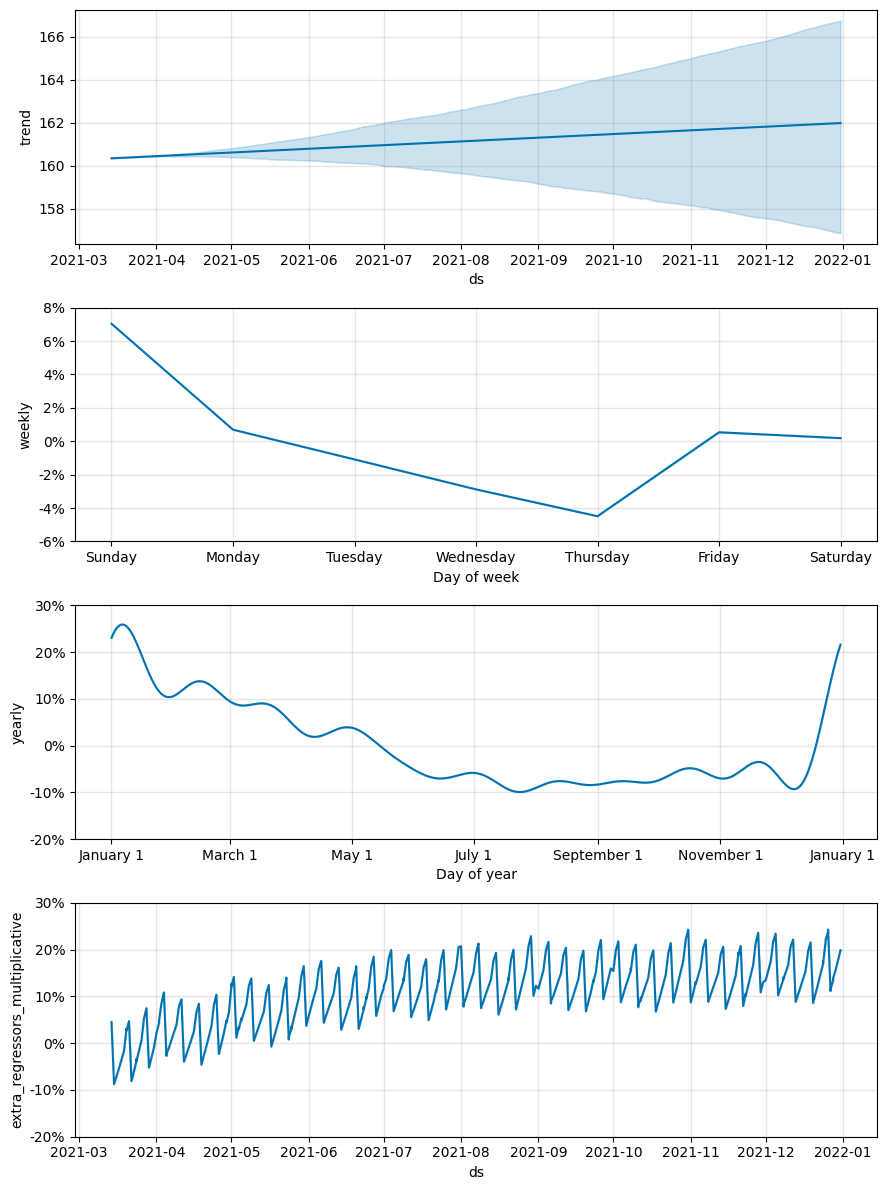

In [21]:
#plot components

fig = model.plot_components(validation_forecast)


In [22]:
# At this point, we need to create a SMAPE score and see how well this model has performed

from sklearn.metrics import mean_absolute_error

def smape_score(y_true, y_pred):
    """
    Calculate the Symmetric Mean Absolute Percentage Error (SMAPE) score.

    Parameters:
        y_true (array-like): Array of true target values.
        y_pred (array-like): Array of predicted target values.

    Returns:
        float: SMAPE score.
    """
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred)
    smape = np.mean(diff / denominator) * 100
    return smape

# Go ahead and make this function as welll for late

def calculate_smape_scores(y_true, y_catboost, y_prophet):
    """
    Calculate SMAPE scores for two models: CatBoost and Prophet (multiplicative).

    Parameters:
        y_true (array-like): Array of true target values.
        y_catboost (array-like): Array of target values predicted by CatBoost.
        y_prophet (array-like): Array of target values predicted by Prophet (multiplicative).

    Returns:
        dict: Dictionary containing SMAPE scores for CatBoost and Prophet.
    """
    catboost_smape = smape_score(y_true, y_catboost)
    prophet_smape = smape_score(y_true, y_prophet)
    
    smape_scores = {
        'CatBoost': catboost_smape,
        'Prophet': prophet_smape
    }
    
    return smape_scores


In [23]:
# Find the smape for the val set

smape_validation = smape_score(y_true, y_pred)
print("SMAPE score on validation set:", smape_validation)


SMAPE score on validation set: 84.3290993777982


In [ ]:
# So this is a really bad SMAPE score meaning that the model, though it may be capturing
# the seasonality, is a bad predictor
# So now we move on to a RF and then later a catboost model

In [30]:
# We have to re-do the data because otherwise the time stamp, 'ds', which is required for prophet will cause an error

# What we need now is a validation set derived from the Training data 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Perform Train-Validation Split on the training data

X = df_encoded.drop(columns=['ds', 'y'],axis=1)
y = df_encoded['y']

X_train, X_val, y_train, y_val = train_test_split(X, y,  test_size=0.2, shuffle=False)

scaler = StandardScaler()
scaler.fit(X_train)
scaler_X_train = scaler.transform(X_train)
scaler_X_test = scaler.transform(X_val)

X_train

,id,day,month,year,day_of_week,weekend,is_holiday,month_sin,month_cos,day_sin,...,Category_Using LLMs to Win More Kaggle Competitions,Category_Using LLMs to Write Better,Country_Argentina,Country_Canada,Country_Estonia,Country_Japan,Country_Spain,Store_Kagglazon,Store_Kaggle Learn,Store_Kaggle Store
0,0,1,1,2017,6,1,1,0.5,8.660254e-01,0.201299,...,0,0,1,0,0,0,0,0,1,0
1,1,1,1,2017,6,1,1,0.5,8.660254e-01,0.201299,...,0,0,1,0,0,0,0,0,1,0
2,2,1,1,2017,6,1,1,0.5,8.660254e-01,0.201299,...,0,0,1,0,0,0,0,0,1,0
3,3,1,1,2017,6,1,1,0.5,8.660254e-01,0.201299,...,1,0,1,0,0,0,0,0,1,0
4,4,1,1,2017,6,1,1,0.5,8.660254e-01,0.201299,...,0,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115030,115030,14,3,2021,6,1,0,1.0,6.123234e-17,0.299363,...,0,0,0,0,0,1,0,1,0,0
115031,115031,14,3,2021,6,1,0,1.0,6.123234e-17,0.299363,...,0,0,0,0,0,1,0,1,0,0
115032,115032,14,3,2021,6,1,0,1.0,6.123234e-17,0.299363,...,0,0,0,0,0,1,0,1,0,0
115033,115033,14,3,2021,6,1,0,1.0,6.123234e-17,0.299363,...,1,0,0,0,0,1,0,1,0,0


In [31]:
from sklearn.ensemble import RandomForestRegressor

rfc = RandomForestRegressor(n_estimators=500).fit(X_train, y_train)

from sklearn.metrics import mean_absolute_error, mean_squared_error
# We evaluate our model based on 4 errors
pred_rfc_model = rfc.predict(X_val) # This is very much the validation 
print('MAE:', mean_absolute_error(y_val, pred_rfc_model))
print('RMSE:', mean_squared_error(y_val, pred_rfc_model)**0.5)
print('MSE:',mean_squared_error(y_val, pred_rfc_model))
print('SMAPE:',smape_score(y_val, pred_rfc_model))

#so smape is about 9 for this which is significantly better than the multiplicative prophet score


MAE: 16.661683413187315
RMSE: 33.8663314706474
MSE: 1146.9284072797625
SMAPE: 9.030950305809853


In [42]:
test_encoded3

,id,ds,day,month,year,day_of_week,weekend,is_holiday,month_sin,month_cos,...,Category_Using LLMs to Win More Kaggle Competitions,Category_Using LLMs to Write Better,Country_Argentina,Country_Canada,Country_Estonia,Country_Japan,Country_Spain,Store_Kagglazon,Store_Kaggle Learn,Store_Kaggle Store
0,136950,2022-01-01,1,1,2022,5,1,1,5.000000e-01,0.866025,...,0,0,1,0,0,0,0,0,1,0
1,136951,2022-01-01,1,1,2022,5,1,1,5.000000e-01,0.866025,...,0,0,1,0,0,0,0,0,1,0
2,136952,2022-01-01,1,1,2022,5,1,1,5.000000e-01,0.866025,...,0,0,1,0,0,0,0,0,1,0
3,136953,2022-01-01,1,1,2022,5,1,1,5.000000e-01,0.866025,...,1,0,1,0,0,0,0,0,1,0
4,136954,2022-01-01,1,1,2022,5,1,1,5.000000e-01,0.866025,...,0,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27370,164320,2022-12-31,31,12,2022,5,1,0,-2.449294e-16,1.000000,...,0,0,0,0,0,0,1,1,0,0
27371,164321,2022-12-31,31,12,2022,5,1,0,-2.449294e-16,1.000000,...,0,0,0,0,0,0,1,1,0,0
27372,164322,2022-12-31,31,12,2022,5,1,0,-2.449294e-16,1.000000,...,0,0,0,0,0,0,1,1,0,0
27373,164323,2022-12-31,31,12,2022,5,1,0,-2.449294e-16,1.000000,...,1,0,0,0,0,0,1,1,0,0


In [43]:
#So now, we are going to use this for the competition to see how our score is affected


test_encoded3.drop('ds', axis=1, inplace=True)

test_encoded3

,id,day,month,year,day_of_week,weekend,is_holiday,month_sin,month_cos,day_sin,...,Category_Using LLMs to Win More Kaggle Competitions,Category_Using LLMs to Write Better,Country_Argentina,Country_Canada,Country_Estonia,Country_Japan,Country_Spain,Store_Kagglazon,Store_Kaggle Learn,Store_Kaggle Store
0,136950,1,1,2022,5,1,1,5.000000e-01,0.866025,2.012985e-01,...,0,0,1,0,0,0,0,0,1,0
1,136951,1,1,2022,5,1,1,5.000000e-01,0.866025,2.012985e-01,...,0,0,1,0,0,0,0,0,1,0
2,136952,1,1,2022,5,1,1,5.000000e-01,0.866025,2.012985e-01,...,0,0,1,0,0,0,0,0,1,0
3,136953,1,1,2022,5,1,1,5.000000e-01,0.866025,2.012985e-01,...,1,0,1,0,0,0,0,0,1,0
4,136954,1,1,2022,5,1,1,5.000000e-01,0.866025,2.012985e-01,...,0,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27370,164320,31,12,2022,5,1,0,-2.449294e-16,1.000000,-2.449294e-16,...,0,0,0,0,0,0,1,1,0,0
27371,164321,31,12,2022,5,1,0,-2.449294e-16,1.000000,-2.449294e-16,...,0,0,0,0,0,0,1,1,0,0
27372,164322,31,12,2022,5,1,0,-2.449294e-16,1.000000,-2.449294e-16,...,0,0,0,0,0,0,1,1,0,0
27373,164323,31,12,2022,5,1,0,-2.449294e-16,1.000000,-2.449294e-16,...,1,0,0,0,0,0,1,1,0,0


In [44]:
pred = rfc.predict(test_encoded3)
test_encoded3['num_sold'] = pred
pred


array([ 25.192,  27.192,   4.072, ..., 106.818, 660.62 , 535.398])

In [45]:
test_encoded3.head(5)

,id,day,month,year,day_of_week,weekend,is_holiday,month_sin,month_cos,day_sin,...,Category_Using LLMs to Write Better,Country_Argentina,Country_Canada,Country_Estonia,Country_Japan,Country_Spain,Store_Kagglazon,Store_Kaggle Learn,Store_Kaggle Store,num_sold
0,136950,1,1,2022,5,1,1,0.5,0.866025,0.201299,...,0,1,0,0,0,0,0,1,0,25.192
1,136951,1,1,2022,5,1,1,0.5,0.866025,0.201299,...,0,1,0,0,0,0,0,1,0,27.192
2,136952,1,1,2022,5,1,1,0.5,0.866025,0.201299,...,0,1,0,0,0,0,0,1,0,4.072
3,136953,1,1,2022,5,1,1,0.5,0.866025,0.201299,...,0,1,0,0,0,0,0,1,0,24.100
4,136954,1,1,2022,5,1,1,0.5,0.866025,0.201299,...,1,1,0,0,0,0,0,1,0,23.226


In [46]:
submission_late_final = pd.read_csv('sample_submission.csv')
submission_late_final['num_sold'] = test_encoded3['num_sold']
submission_late_final.head()

,id,num_sold
0,136950,25.192
1,136951,27.192
2,136952,4.072
3,136953,24.100
4,136954,23.226


In [47]:
submission_late_final['num_sold'].unique()

array([ 25.192,  27.192,   4.072, ..., 106.818, 660.62 , 535.398])

In [48]:
submission_late_final.to_csv('submission_late_final.csv', index=False)

In [39]:
# I don't have enough memory to do this for this competition. Perhaps with a newer more powerful machine. 

# Try CatBoost --> Gradient boosting for categorical variables 
# Memory intensive for low ram laptops (as expected)

# !pip install catboost


  Using cached catboost-1.2.tar.gz (95.9 MB)
  Installing build dependencies ... error
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [533 lines of output]
        Obtaining dependency information for setuptools>=64.0 from https://files.pythonhosted.org/packages/c7/42/be1c7bbdd83e1bfb160c94b9cafd8e25efc7400346cf7ccdbdb452c467fa/setuptools-68.0.0-py3-none-any.whl.metadata
        Obtaining dependency information for wheel from https://files.pythonhosted.org/packages/17/11/f139e25018ea2218aeedbedcf85cd0dd8abeed29a38ac1fda7f5a8889382/wheel-0.41.0-py3-none-any.whl.metadata
        Obtaining dependency information for jupyterlab from https://files.pythonhosted.org/packages/5f/d5/176f1cf19b87ede0001093c1008260cfa251d4b2e6c82fd294890462692a/jupyterlab-3.6.5-py3-none-any.whl.metadata
           ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/781.0 kB ? eta -:--:--
           ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━

In [37]:
#For later ... not enough computing power for this right now. 

# from catboost import CatBoostRegressor

# # Create and fit the CatBoost model
# catboost_model = CatBoostRegressor(n_estimators=500, verbose=0)
# catboost_model.fit(X_train, y_train)

# # Make predictions on the validation set
# pred_catboost_model = catboost_model.predict(X_val)

# # Evaluate the model based on the 4 errors
# print('MAE:', mean_absolute_error(y_val, pred_catboost_model))
# print('RMSE:', mean_squared_error(y_val, pred_catboost_model)**0.5)
# print('MSE:', mean_squared_error(y_val, pred_catboost_model))
# print('SMAPE:', smape_score(y_val, pred_catboost_model))


ModuleNotFoundError: No module named 'catboost'